In [49]:
import copy
import random
import math
import time
import pickle
import pprint

import tqdm

import numpy
import pandas

import sklearn
import sklearn.metrics
import sklearn.svm

import xgboost

import matplotlib
import matplotlib.pyplot
import seaborn

# Utility functions

In [2]:
def equal_pdf(size):
    return numpy.ones((size,)) / size

In [3]:
def normalize_pdf(x):
    x = x / x.sum()
    x = numpy.nan_to_num(x, copy=True, nan=0.0, posinf=None, neginf=None)
    if x.sum() == 0.:
        x = equal_pdf(x.shape[0])
    return x

In [4]:
def get_k_accuracy_for_target(x, target):
    x = pandas.Series(x).sort_values(ascending=False).reset_index()
    return x[x['index']==target].index[0] + len(x[x[0]==x[x['index']==target].iloc[0][0]].index)/2

In [5]:
def target_pdf(size, target):
    x = numpy.zeros((size,))
    x[target] = 1
    return x

# Opinion pools

In [6]:
def majority_vote(X):
    votes = X.argmax(axis=1)
    vote = pandas.Series(votes).value_counts().sort_index().idxmax()
    return target_pdf(X.shape[1], vote)

In [7]:
def linear_opinion_pool(X):
    x = X.sum(axis=0)
    return normalize_pdf(x)

In [8]:
def logarithmic_opinion_pool(X):
    x = X.prod(axis=0)
    return normalize_pdf(x)

In [9]:
def paired_opinion_pool(X, pool1, pool2):
    Y = []
    for i in range(X.shape[0]):
        for j in range(i+1, X.shape[0]):
            Y.append(pool1(numpy.array([X[i, :], X[j, :]])))
    Y = numpy.array(Y)
    return pool2(Y)

In [10]:
class PairedOpinionPool:
    def __init__(self, pool1, pool2):
        self.pool1 = pool1
        self.pool2 = pool2
        
    def __call__(self, X):
        return paired_opinion_pool(X, self.pool1, self.pool2)

In [11]:
logarithmic_linear_opinion_pool = PairedOpinionPool(logarithmic_opinion_pool, linear_opinion_pool)

# Configuration

In [81]:
# 100000
EXPERIMENT_SIZE = 100000
ROLLING_WINDOW_SIZE = EXPERIMENT_SIZE//10
# 128
ACTORS = 128
# 8
FEATURES = 8

# 0.1
BASE_ACTIVITY = 0.1
BASE_STD = 1/ACTORS

ACTIVITY_SHIFT_STD = 1e-2
MEAN_SHIFT_STD = 1e-2
STD_SHIFT_STD = 1e-2

TRAIN_SIZE = 0.5

PROB_FALSE_FLAG = 0.4

MODELS = {
    # 'Naive Bayes': sklearn.naive_bayes.GaussianNB(),
    'Linear SVM': sklearn.svm.SVC(kernel='linear', probability=True),
    # 'SVM with RBF': sklearn.svm.SVC(probability=True),
    # 'MLP': sklearn.neural_network.MLPClassifier(early_stopping=True),
    'XGBoost': xgboost.XGBClassifier(n_estimators=1000, n_jobs=1, objective='multi_softmax')
}
MODEL = MODELS['Linear SVM']

FIGSIZE = (8, 4)

In [13]:
pools = {
    # 'Majority Vote': majority_vote, 
    'Linear Opinion Pool': linear_opinion_pool, 
    'Logarithmic Opinion Pool': logarithmic_opinion_pool,
    'Pairing Aggregator': logarithmic_linear_opinion_pool,
}

# Experiment

In [14]:
feature_names = [f'x{i}' for i in range(FEATURES)]

## Prepare dataset

In [ ]:
columns = [
    'Name',
    'start',
    'end',
    'activity',
]

for i in range(FEATURES):
    columns.append(f'x{i}_mean')
    columns.append(f'x{i}_std')

df_actors = pandas.DataFrame(columns=columns)

for i in range(ACTORS):
    start = random.uniform(0, EXPERIMENT_SIZE * (TRAIN_SIZE - 0.1))
    end = random.uniform(EXPERIMENT_SIZE * (TRAIN_SIZE + 0.1), EXPERIMENT_SIZE)

    values = [
        'APT'+str(i),
        start,
        end,
        random.uniform(0.0001, BASE_ACTIVITY),
    ]
    for _ in range(FEATURES):
        values.append(random.uniform(-1, 1))
        values.append(random.uniform(0, BASE_STD))

    df_actors.loc[i] = pandas.Series(
        values,
        index=df_actors.columns,
        name=i,
    )


In [ ]:
df_actors

,Name,start,end,activity,x0_mean,x0_std,x1_mean,x1_std,x2_mean,x2_std,x3_mean,x3_std,x4_mean,x4_std,x5_mean,x5_std,x6_mean,x6_std,x7_mean,x7_std
0,APT0,28706.74534,71522.773839,0.077005,-0.820592,0.002832,0.27332,0.005723,0.407798,0.002934,-0.240162,0.005786,-0.306415,0.003061,-0.354689,0.000621,-0.677331,0.004643,0.004811,0.00569
1,APT1,22885.572764,75358.394044,0.011253,-0.318926,0.004806,0.967,0.006445,0.482932,0.006152,0.696349,0.003473,0.175878,0.004689,0.800283,0.005346,-0.67634,0.005998,-0.961339,0.00058
2,APT2,13686.340629,87194.596239,0.053374,0.02996,0.005948,0.763969,0.00645,0.26125,0.001815,0.939208,0.003766,0.977583,0.006245,-0.753842,0.001502,0.246647,0.00314,0.96053,0.000863
3,APT3,15469.753789,67852.004096,0.059287,-0.624815,0.003561,-0.344747,0.000783,-0.336424,0.006418,0.419702,0.003588,-0.055239,0.004288,0.886934,0.006477,0.094761,0.004823,0.306553,0.002409
4,APT4,2513.049464,60474.967226,0.022255,0.732821,0.005297,-0.72749,0.000851,0.158977,0.002643,-0.177384,0.004338,0.966511,0.002831,0.651822,0.001268,-0.859898,0.00633,-0.191439,0.002715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,APT123,4746.413984,63921.918377,0.070892,0.348162,0.000862,-0.984142,0.005359,0.580728,0.007765,-0.448492,0.000902,0.878032,0.000874,0.990198,0.006893,0.167481,0.000807,0.851596,0.00069
124,APT124,328.686421,62304.434566,0.034007,-0.638509,0.001475,0.510368,0.007755,0.319787,0.005712,0.538152,0.002927,0.7046,0.006245,-0.756329,0.002538,0.741324,0.000657,0.860774,0.005362
125,APT125,34360.803777,63463.481633,0.082748,-0.039965,0.005816,0.359279,0.001522,0.483778,0.001153,0.627422,0.002602,0.732864,0.00374,-0.027154,0.002697,0.822893,0.000383,-0.040601,0.000819
126,APT126,19682.10523,64356.315571,0.077507,0.639574,0.002925,0.538404,0.001846,-0.630967,0.00343,0.879191,0.003559,0.751754,0.001549,0.514178,0.004466,0.830439,0.004617,0.090496,0.00129


In [ ]:
columns = [
    'Name',
    'Timestep',
] + feature_names

df_incidents = pandas.DataFrame(columns=columns)

incident_i = 0
for i in tqdm.tqdm(range(EXPERIMENT_SIZE)):
    for j in range(ACTORS):
        if df_actors.iloc[j]['start'] <= i and df_actors.iloc[j]['end'] >= i and random.uniform(0, 1) < df_actors.iloc[j]['activity']:
            feature_values = [
                random.normalvariate(
                    df_actors.iloc[j][f'x{k}_mean'], df_actors.iloc[j][f'x{k}_std']
                )
                for k in range(FEATURES)
            ]

            # If generating test data already, introduce false flags corresponding to a sample from another actor present in the training data
            if i > EXPERIMENT_SIZE * TRAIN_SIZE:
                # if len(df_incidents[(df_incidents['Name'] != df_actors.iloc[j]['Name'])].index) > 0:
                blamed_actor = df_incidents[
                    (df_incidents['Name'] != df_actors.iloc[j]['Name'])
                    & (df_incidents['Timestep'] < EXPERIMENT_SIZE * TRAIN_SIZE)
                ]['Name'].sample(1)[0]
                for k in range(FEATURES):
                    if random.uniform(0, 1) < PROB_FALSE_FLAG:
                        feature_values[k] = df_incidents[
                            (df_incidents['Name'] == blamed_actor)
                            & (df_incidents['Timestep'] < EXPERIMENT_SIZE * TRAIN_SIZE)
                        ][f'x{k}'].sample(1)[0]

            values = [
                df_actors.iloc[j]['Name'],
                i,
            ] + feature_values

            series_index = str(i)+str(',')+str(j)

            df_incidents.loc[series_index] = pandas.Series(
                values,
                index=df_incidents.columns,
                name=series_index,
            )
            incident_i += 1

    for k in range(FEATURES):
        df_actors.loc[j, 'activity'] = min(
            max(
                df_actors.loc[j, 'activity'] +
                random.normalvariate(0, ACTIVITY_SHIFT_STD),
                0
            ),
            BASE_ACTIVITY
        )

        df_actors.loc[j, f'x{k}_mean'] = min(
            max(
                df_actors.loc[j, f'x{k}_mean'] +
                random.normalvariate(0, MEAN_SHIFT_STD),
                -1
            ),
            1
        )

        df_actors.loc[j, f'x{k}_std'] = min(
            max(
                df_actors.loc[j, f'x{k}_std'] +
                random.normalvariate(0, STD_SHIFT_STD),
                0
            ),
            BASE_STD
        )

    if i % 1000 == 0:
        df_incidents = df_incidents.copy()
0

100%|██████████| 100000/100000 [14:54:06<00:00,  1.86it/s]  


0

In [ ]:
df_actors

,Name,start,end,activity,x0_mean,x0_std,x1_mean,x1_std,x2_mean,x2_std,x3_mean,x3_std,x4_mean,x4_std,x5_mean,x5_std,x6_mean,x6_std,x7_mean,x7_std
0,APT0,28706.74534,71522.773839,0.077005,-0.820592,0.002832,0.27332,0.005723,0.407798,0.002934,-0.240162,0.005786,-0.306415,0.003061,-0.354689,0.000621,-0.677331,0.004643,0.004811,0.00569
1,APT1,22885.572764,75358.394044,0.011253,-0.318926,0.004806,0.967,0.006445,0.482932,0.006152,0.696349,0.003473,0.175878,0.004689,0.800283,0.005346,-0.67634,0.005998,-0.961339,0.00058
2,APT2,13686.340629,87194.596239,0.053374,0.02996,0.005948,0.763969,0.00645,0.26125,0.001815,0.939208,0.003766,0.977583,0.006245,-0.753842,0.001502,0.246647,0.00314,0.96053,0.000863
3,APT3,15469.753789,67852.004096,0.059287,-0.624815,0.003561,-0.344747,0.000783,-0.336424,0.006418,0.419702,0.003588,-0.055239,0.004288,0.886934,0.006477,0.094761,0.004823,0.306553,0.002409
4,APT4,2513.049464,60474.967226,0.022255,0.732821,0.005297,-0.72749,0.000851,0.158977,0.002643,-0.177384,0.004338,0.966511,0.002831,0.651822,0.001268,-0.859898,0.00633,-0.191439,0.002715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,APT123,4746.413984,63921.918377,0.070892,0.348162,0.000862,-0.984142,0.005359,0.580728,0.007765,-0.448492,0.000902,0.878032,0.000874,0.990198,0.006893,0.167481,0.000807,0.851596,0.00069
124,APT124,328.686421,62304.434566,0.034007,-0.638509,0.001475,0.510368,0.007755,0.319787,0.005712,0.538152,0.002927,0.7046,0.006245,-0.756329,0.002538,0.741324,0.000657,0.860774,0.005362
125,APT125,34360.803777,63463.481633,0.082748,-0.039965,0.005816,0.359279,0.001522,0.483778,0.001153,0.627422,0.002602,0.732864,0.00374,-0.027154,0.002697,0.822893,0.000383,-0.040601,0.000819
126,APT126,19682.10523,64356.315571,0.077507,0.639574,0.002925,0.538404,0.001846,-0.630967,0.00343,0.879191,0.003559,0.751754,0.001549,0.514178,0.004466,0.830439,0.004617,0.090496,0.00129


In [ ]:
df_incidents

,Name,Timestep,x0,x1,x2,x3,x4,x5,x6,x7
"157,5",APT5,157,0.165575,0.478021,0.54325,-0.93793,-0.931223,-0.902985,-0.841161,0.181773
"168,5",APT5,168,0.165628,0.477952,0.548967,-0.936848,-0.924607,-0.900543,-0.850106,0.165962
"208,5",APT5,208,0.164336,0.477998,0.537964,-0.938837,-0.941115,-0.901665,-0.831019,0.176477
"243,5",APT5,243,0.162881,0.47797,0.537589,-0.941488,-0.938519,-0.901864,-0.843723,0.171911
"333,124",APT124,333,-0.637978,0.514327,0.321225,0.539044,0.706843,-0.755271,0.741007,0.856741
...,...,...,...,...,...,...,...,...,...,...
"99758,20",APT20,99758,-0.980243,-0.903211,0.035211,-0.114349,0.9851,-0.456833,-0.807037,0.896355
"99796,37",APT37,99796,0.310684,-0.498707,-0.454661,0.75608,-0.640071,0.25557,0.24839,-0.832962
"99810,37",APT37,99810,-0.852118,-0.507844,0.933745,-0.469913,0.030024,0.257686,0.248039,-0.833692
"99845,37",APT37,99845,-0.042967,0.360498,0.921839,0.625446,-0.649429,0.252656,0.246344,-0.040976


# Describe dataset

In [ ]:
df_incidents.describe()

,Name,Timestep,x0,x1,x2,x3,x4,x5,x6,x7
count,392577,392577,392577.0,392577.000000,392577.000000,392577.000000,392577.0,392577.0,392577.000000,392577.000000
unique,128,89905,318327.0,318126.000000,318034.000000,318177.000000,318145.0,318108.0,318514.000000,317983.000000
top,APT81,59210,-1.0,0.645827,0.553069,0.169223,1.0,-1.0,-0.841789,-0.840479
freq,7529,21,10.0,7.000000,6.000000,7.000000,19.0,10.0,6.000000,6.000000


In [ ]:
df_incidents[['Timestep'] + feature_names].describe()

,Timestep,x0,x1,x2,x3,x4,x5,x6,x7
count,392577.000000,392577.000000,392577.000000,392577.000000,392577.000000,392577.000000,392577.000000,392577.000000,392577.000000
mean,48487.939136,-0.030761,0.069582,-0.052340,0.125891,0.128176,0.070693,-0.054770,0.048388
std,21394.174586,0.589163,0.565915,0.548706,0.593997,0.605565,0.630383,0.582353,0.574928
min,157.000000,-1.020642,-1.016341,-1.016064,-1.005816,-1.010904,-1.013426,-1.004727,-1.009938
25%,32623.000000,-0.563940,-0.398511,-0.529141,-0.315189,-0.401703,-0.547926,-0.635384,-0.479469
50%,48404.000000,-0.027718,0.018178,-0.061391,0.178514,0.181388,0.154160,-0.107864,0.076330
75%,63972.000000,0.509634,0.557532,0.370586,0.625330,0.644630,0.645416,0.524748,0.545567
max,99848.000000,1.009356,1.003642,1.009983,1.017823,1.015125,1.019453,0.968629,1.015917


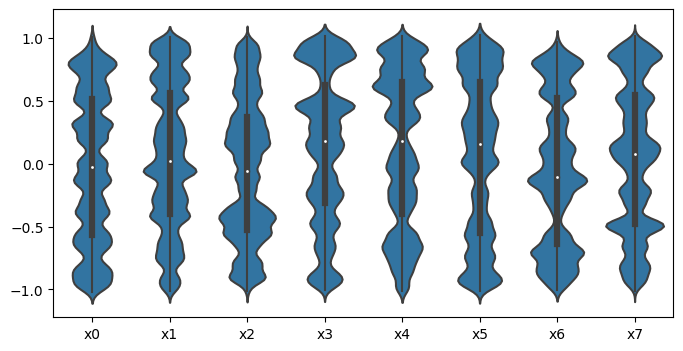

In [42]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)

fg = seaborn.violinplot(data=df_incidents[feature_names], inner='box', color=seaborn.color_palette()[0])

fig.savefig('feature-distributions.pdf', dpi=600, bbox_inches='tight')

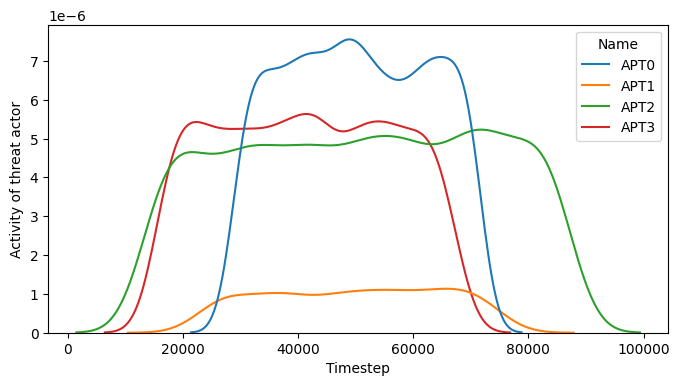

In [41]:
n_actors_shown = 4

shown_actors = [f'APT{i}' for i in range(n_actors_shown)]

fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)

fg = seaborn.kdeplot(
    data=df_incidents[df_incidents['Name'].apply(lambda x: x in shown_actors)],
    x='Timestep',
    hue="Name",
    hue_order=shown_actors,
)

fg.set_ylabel('Activity of threat actor')

fig.savefig('threat-actor-activity.pdf', dpi=600, bbox_inches='tight')

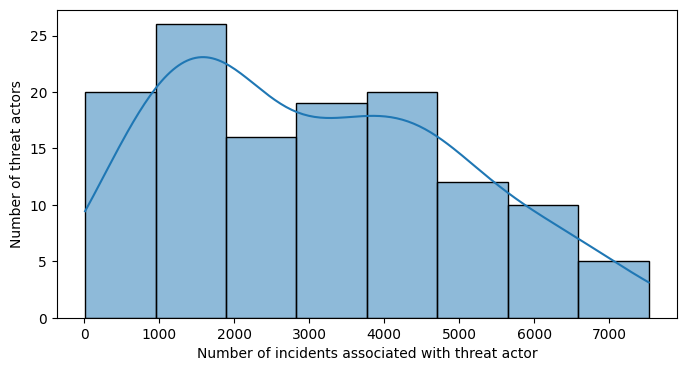

In [44]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)

fg = seaborn.histplot(
    data=df_incidents['Name'].value_counts(), 
    kde=True,
)

fg.set_xlabel('Number of incidents associated with threat actor')
fg.set_ylabel('Number of threat actors')

fig.savefig('threat-actor-hist.pdf', dpi=600, bbox_inches='tight')

# Load/save dataset

In [ ]:
df_incidents.to_csv('df_incidents.csv')

In [15]:
df_incidents = pandas.read_csv('df_incidents.csv')

# Split dataset

In [102]:
df_train = df_incidents[df_incidents['Timestep'] < EXPERIMENT_SIZE * TRAIN_SIZE]
df_test = df_incidents[df_incidents['Timestep'] >= EXPERIMENT_SIZE * TRAIN_SIZE]

len(df_train), len(df_test)

(206511, 186066)

In [103]:
df_train['Name'] = df_train['Name'].apply(lambda x: int(x[3:]))
df_test['Name'] = df_test['Name'].apply(lambda x: int(x[3:]))

C:\Users\20173892\AppData\Local\Temp\ipykernel_19428\4255208019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Name'] = df_train['Name'].apply(lambda x: int(x[3:]))
C:\Users\20173892\AppData\Local\Temp\ipykernel_19428\4255208019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Name'] = df_test['Name'].apply(lambda x: int(x[3:]))


## Run experiment

In [104]:
runtimes = {}

In [105]:
models = [
    copy.deepcopy(MODEL)
    for _ in range(FEATURES)
]

t1 = time.process_time()
for i in tqdm.tqdm(range(FEATURES)):
    models[i].fit(df_train[[f'x{i}']].to_numpy(), df_train['Name'])
t2 = time.process_time()
runtimes['Training Modules'] = t2 - t1

100%|██████████| 8/8 [56:13<00:00, 421.69s/it]


In [106]:
preds = []
t1 = time.process_time()
for i in tqdm.tqdm(range(FEATURES)):
    preds.append(models[i].predict_proba(df_test[[f'x{i}']].to_numpy()))
t2 = time.process_time()
runtimes['Prediction Modules'] = t2 - t1

100%|██████████| 8/8 [10:59:42<00:00, 4947.79s/it] 


In [107]:
df_pools = []

In [108]:
for model_name, model_base in tqdm.tqdm(MODELS.items()):
    model = copy.deepcopy(model_base)
    t1 = time.process_time()
    model.fit(df_train[feature_names].to_numpy(), df_train['Name'])
    t2 = time.process_time()
    runtimes[f'Training {model_name}'] = t2 - t1
    
    probs_correct = numpy.zeros(len(df_test))
    probs_incorrect = numpy.zeros(len(df_test))
    k_accurates_correct = numpy.zeros(len(df_test))
    times = numpy.zeros(len(df_test))
    names = numpy.zeros(len(df_test))

    t1 = time.process_time()
    
    for i in range(len(df_test)):
        if not isinstance(df_test.iloc[i]['Name'], str):
            apt_i = df_test.iloc[i]['Name']
        else:
            apt_i = int(df_test.iloc[i]['Name'][3:])

        c = model.predict_proba(df_test.iloc[i][feature_names].to_numpy().reshape(1, FEATURES)).reshape(ACTORS)
        target = target_pdf(ACTORS, apt_i)

        probs_correct[i] = c[apt_i]
        probs_incorrect[i] = c[c != c[apt_i]].max() if c.max() != c.min() else c[apt_i]
        k_accurates_correct[i] = get_k_accuracy_for_target(c, apt_i)

        times[i] = df_test.iloc[i]['Timestep']
        names[i] = apt_i
        
    t2 = time.process_time()
    runtimes[f'Prediction {model_name}'] = t2 - t1

    df_pool = pandas.DataFrame(
        numpy.array([probs_correct, probs_incorrect, k_accurates_correct, times, names]).transpose(), 
        columns=['Probability of correct attribution', 'Probability of incorrect attribution', 'k-Accuracy', 'Timestep', 'Name']
    )
    df_pool['Method'] = model_name
    df_pools.append(df_pool)

 50%|█████     | 1/2 [07:04<07:04, 424.09s/it]c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
100%|██████████| 2/2 [42:14<00:00, 1267.31s/it]


In [109]:
for pool_name, pool in tqdm.tqdm(pools.items()):
    entropies_x = numpy.zeros(len(df_test))
    entropies_y = numpy.zeros(len(df_test))
    entropies_z = numpy.zeros(len(df_test))
    entropies_c = numpy.zeros(len(df_test))
    joint_entropies = numpy.zeros(len(df_test))
    conditional_entropies = numpy.zeros(len(df_test))
    probs_correct = numpy.zeros(len(df_test))
    probs_incorrect = numpy.zeros(len(df_test))
    k_accurates_correct = numpy.zeros(len(df_test))
    times = numpy.zeros(len(df_test))
    names = numpy.zeros(len(df_test))
    
    t1 = time.process_time()
    
    for i in range(len(df_test)):
        if not isinstance(df_test.iloc[i]['Name'], str):
            apt_i = df_test.iloc[i]['Name']
        else:
            apt_i = int(df_test.iloc[i]['Name'][3:])

        c = pool(numpy.array([preds[j][i] for j in range(FEATURES)]))
        target = target_pdf(ACTORS, apt_i)
        
        probs_correct[i] = c[apt_i]
        probs_incorrect[i] = c[c != c[apt_i]].max() if c.max() != c.min() else c[apt_i]
        k_accurates_correct[i] = get_k_accuracy_for_target(c, apt_i)
        
        times[i] = df_test.iloc[i]['Timestep']
        names[i] = apt_i
        
    t2 = time.process_time()
    runtimes[f'Prediction {pool_name}'] = t2 - t1

    df_pool = pandas.DataFrame(
        numpy.array([probs_correct, probs_incorrect, k_accurates_correct, times, names]).transpose(), 
        columns=['Probability of correct attribution', 'Probability of incorrect attribution', 'k-Accuracy', 'Timestep', 'Name']
    )
    df_pool['Method'] = pool_name
    df_pools.append(df_pool)

100%|██████████| 3/3 [09:52<00:00, 197.51s/it]


In [110]:
df = pandas.concat(df_pools)

df['prediction'] = df.apply(lambda x: 'correct' if x['Probability of correct attribution'] > x['Probability of incorrect attribution'] else 'incorrect', axis=1)
df['correct'] = (df['prediction'] == 'correct')
df['incorrect'] = (df['prediction'] == 'incorrect')

# Load/save results

In [111]:
df.to_csv('df_results.csv')
with open('runtimes.pickle', 'wb') as file:
    pickle.dump(runtimes, file)

In [112]:
df = pandas.read_csv('df_results.csv')
with open('runtimes.pickle', 'rb') as file:
    runtimes = pickle.load(file)

# Results

## Precision-Recall

In [113]:
# Precision-Recall
df_pools = []

for pool in tqdm.tqdm(df['Method'].unique()):
    thresholds = set(df[(df['Method']==pool) & (df['correct']==True)]['Probability of correct attribution'])
    thresholds = thresholds.union(set(df[(df['Method']==pool) & (df['incorrect']==True)]['Probability of incorrect attribution']))
    thresholds = set([round(x, 3) for x in thresholds])
    thresholds = [0] + sorted(list(thresholds)) + [1]
    # thresholds = numpy.linspace(1, 100) / 100
    precisions = []
    recalls = []
    for threshold in thresholds:
        # t = len(df[(df['Method'] == pool) & (df['correct']==True)].index)
        t = len(df[(df['Method'] == pool)].index)
        tps = (df[(df['Method'] == pool) & (df['correct']==True)]['Probability of correct attribution'] >= threshold).sum()
        fns = (df[(df['Method'] == pool) & (df['correct']==True)]['Probability of correct attribution'] < threshold).sum()
        fps = (df[(df['Method'] == pool) & (df['incorrect']==True)]['Probability of incorrect attribution'] >= threshold).sum()
        if (tps + fps) > 0:
            precisions.append(tps / (tps + fps))
        else:
            precisions.append(0)
        if t > 0:
            recalls.append(tps / (tps + fns))
        else:
            recalls.append(0)

    df_pool = pandas.DataFrame(
        numpy.array([thresholds, precisions, recalls]).transpose(), 
        columns=['threshold', 'Precision', 'Recall']
    )
    df_pool['Method'] = pool
    df_pools.append(df_pool)

pr_df = pandas.concat(df_pools)

100%|██████████| 5/5 [10:20<00:00, 124.06s/it]


In [114]:
pr_df = pr_df[(pr_df['Precision'] > 0) | (pr_df['Recall'] > 0)]

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

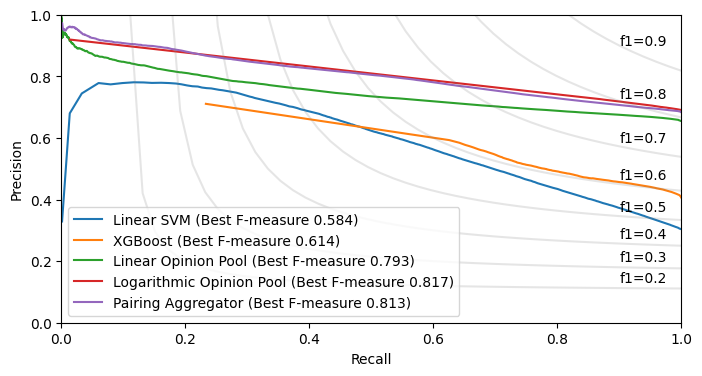

In [115]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

for pool in pr_df['Method'].unique():
    best_f = 0
    best_i = 0
    last_fpr = 0
    last_tpr = 0
    for i, row in pr_df[pr_df['Method']==pool].sort_values('Recall').iterrows():
        if (row['Precision'] + row['Recall']) > 0:
            f = 2 * (row['Precision'] * row['Recall']) / (row['Precision'] + row['Recall'])
            if f > best_f:
                best_f = f
                best_i = i
    seaborn.lineplot(data=pr_df[pr_df['Method']==pool], x='Recall', y='Precision', ax=ax, label=f"{pool} (Best F-measure {best_f:.3f})")
    # seaborn.scatterplot(data=pr_df[(pr_df['Method']==pool) & (pr_df.index==best_i)], x='Recall', y='Precision', ax=ax, marker='x', s=50, legend=False)

f_scores = numpy.linspace(0.2, 0.9, num=8)
lines, labels = [], []
for f_score in f_scores:
    x = numpy.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = matplotlib.pyplot.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    matplotlib.pyplot.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
    
# add the legend for the iso-f1 curves
handles, labels = ax.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])

matplotlib.pyplot.legend(loc='lower left')

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

fig.savefig('pr-curve.pdf', dpi=600, bbox_inches='tight')

## k-Accuracy

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

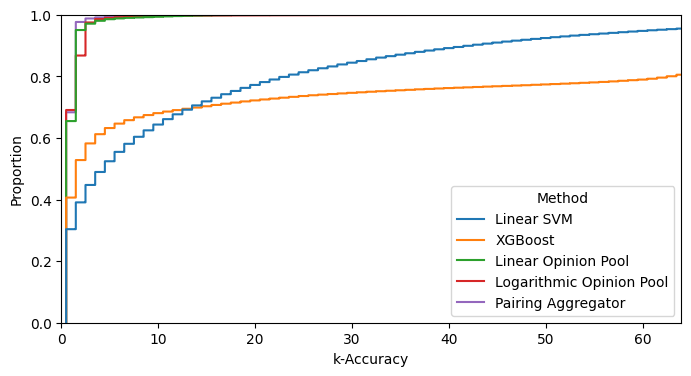

In [116]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)
seaborn.ecdfplot(data=df, x='k-Accuracy', hue='Method', ax=ax)
ax.set_xlim(0, ACTORS/2)
fig.savefig('k-accurate-correct.pdf', dpi=600, bbox_inches='tight')

## Probability of attribution

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

<Axes: xlabel='Probability of correct attribution', ylabel='Proportion'>

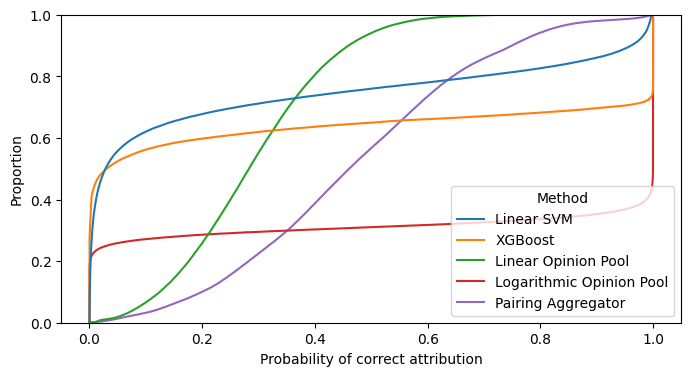

In [117]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)
seaborn.ecdfplot(data=df, x='Probability of correct attribution', hue='Method', ax=ax)

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

<Axes: xlabel='Probability of incorrect attribution', ylabel='Proportion'>

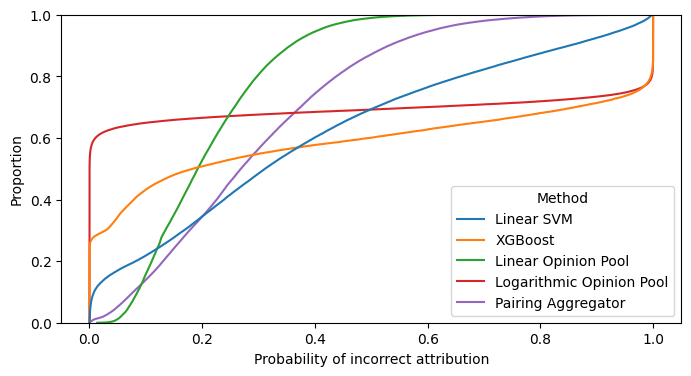

In [118]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)
seaborn.ecdfplot(data=df, x='Probability of incorrect attribution', hue='Method', ax=ax)

## Non-stationarity

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

<Axes: xlabel='Timestep', ylabel='Probability of correct attribution'>

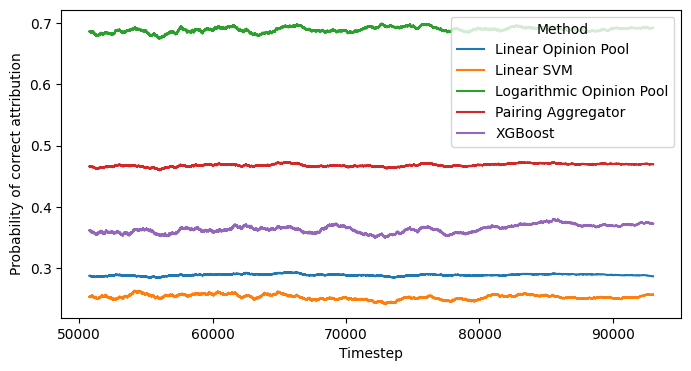

In [119]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)
seaborn.lineplot(data=df[['Method', 'Timestep', 'Probability of correct attribution']].groupby('Method').rolling(ROLLING_WINDOW_SIZE).mean(), x='Timestep', y='Probability of correct attribution', hue='Method', ax=ax)

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

<Axes: xlabel='Timestep', ylabel='Probability of incorrect attribution'>

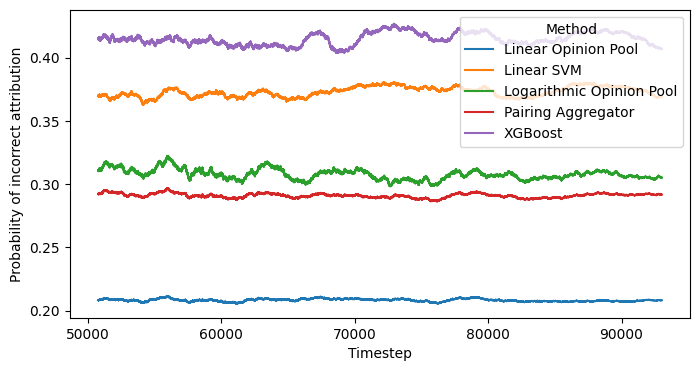

In [120]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)
seaborn.lineplot(data=df[['Method', 'Timestep', 'Probability of incorrect attribution']].groupby('Method').rolling(ROLLING_WINDOW_SIZE).mean(), x='Timestep', y='Probability of incorrect attribution', hue='Method', ax=ax)

## Runtime

In [121]:
temp = [
    'Training Linear SVM',
    'Prediction Linear SVM',
    'Training XGBoost',
    'Prediction XGBoost',
    'Training Modules',
    'Prediction Modules',
    'Prediction Linear Opinion Pool',
    'Prediction Logarithmic Opinion Pool',
    'Prediction Pairing Aggregator',
]

runtimes = {x: runtimes[x] for x in temp}

In [125]:
pprint.pprint(runtimes)

{'Prediction Linear Opinion Pool': 164.109375,
 'Prediction Linear SVM': 398.515625,
 'Prediction Logarithmic Opinion Pool': 160.125,
 'Prediction Modules': 39571.296875,
 'Prediction Pairing Aggregator': 268.1875,
 'Prediction XGBoost': 836.09375,
 'Training Linear SVM': 25.359375,
 'Training Modules': 3369.171875,
 'Training XGBoost': 1291.875}


In [127]:
pprint.pprint({k:(v/60) for k,v in runtimes.items()})

{'Prediction Linear Opinion Pool': 2.73515625,
 'Prediction Linear SVM': 6.641927083333333,
 'Prediction Logarithmic Opinion Pool': 2.66875,
 'Prediction Modules': 659.5216145833333,
 'Prediction Pairing Aggregator': 4.469791666666667,
 'Prediction XGBoost': 13.934895833333334,
 'Training Linear SVM': 0.42265625,
 'Training Modules': 56.15286458333333,
 'Training XGBoost': 21.53125}


c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be

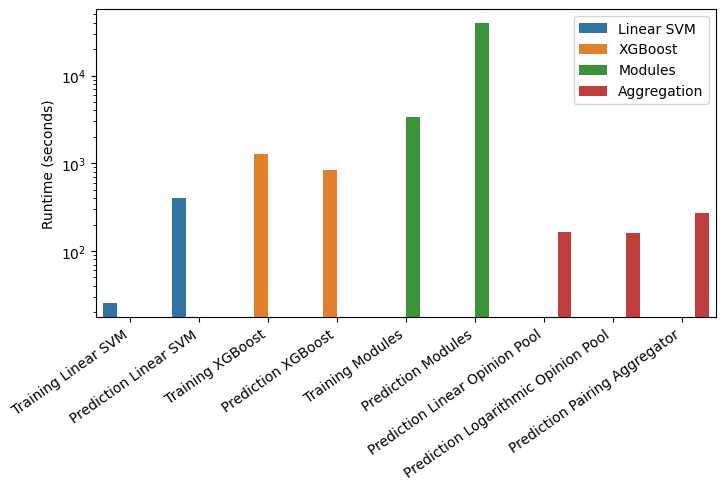

In [123]:
colors = [
    'Linear SVM',
    'Linear SVM',
    'XGBoost',
    'XGBoost',
    'Modules',
    'Modules',
    'Aggregation',
    'Aggregation',
    'Aggregation',
]
colors = [str(x) for x in colors]

fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)
fg = seaborn.barplot(
    x=list(runtimes.keys()),
    y=list(runtimes.values()),
    ax=ax,
    hue=colors,
    dodge=True,
)
fg.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_ylabel('Runtime (seconds)')
fig.savefig('runtime.pdf', dpi=600, bbox_inches='tight')
